## Decision Trees

- Decision trees can perform classification, regression, and even multioutput tasks.
- They are powerful and can fit complex datasets.
- They are the fundamental components of random forests, which are among the most powerful machine learning algorithms available today.
- ***One of the many qualities of decision trees is that they require very little data preparation. In fact they don't require feature scaling or centering at all***.

In [20]:
# Build a decision tree classifier on the iris dataset
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [21]:
iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

In [22]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [23]:
import platform

os_name = platform.system()
print(f"Current OS: {os_name}")

Current OS: Darwin


In [24]:
import os
if "win" in os_name.lower():
    os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
elif "darwin" in os_name.lower():
    os.environ["PATH"] += os.pathsep + "/usr/local/bin:/opt/homebrew/bin"


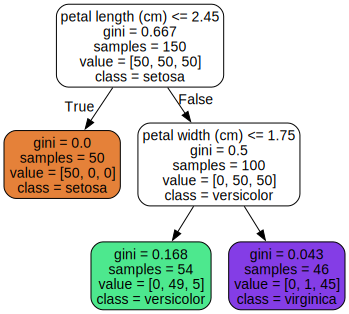

In [25]:
# Visualizing the trained tree
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf, 
    out_file="iris_tree.dot",
    feature_names=["petal length (cm)", "petal width (cm)"],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

Source.from_file("iris_tree.dot")

### Interpretation
- Suppose you find an iris flower and you want to classify it based on its petals.
    - You start at the *root node* (depth 0, at the top): this node asks whether the flower's petal length is smaller than 2.45 cm.
    - If it is, then you move down to the root's left child node (depth 1, left).
        - In this case, it is a *leaf node* (i.e. it does not have any child nodes), so it does not ask any questions: simply look at the the predicted class for that node, and the decision tree predicts that your flower is an *Iris setosa* `(class=setosa)`.
- Now suppose you find another flower, and this time the petal length is greater than 2.45cm.
    - You again start at the root but now move down to its right child node (depth 1, right). 
    - This is not a leaf node, it's a *split node*, so it asks another question: is the petal width smaller than 1.75cm?
    - If it is, then your flower is most likely an *Iris versicolor* (depth 2, left).
    - If not, it is likely an *Iris virginica* (depth 2, right).

### Explaining the different fields in each node
- `samples`:
    - A node's `samples` attribute counts how many training instances it applies to.
    - For example, 100 training instances have a petal length greater than 2.45cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75cm (depth 2, left).
- `value`:
    - A node's `value` attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *Iris setosa*, 1 *Iris versicolor*, and 45 *Iris virginica*. 
- `gini`:
    - A node's `gini` attribute measures its *Gini impurity*: a node is "pure" `(gini=0)` if all training instances it applies to belong to the same class.
    - For example, since the depth-1 left node applies only to *Iris setosa* training instances, it is pure and its Gini impurity is 0. 
    - *Gini impurity calculation of the ith node, where $k$ is the class:*
    $$
    G_i = 1 - \sum^n_{k=1}p_{i, k}^2
    $$
    - where:
        - $G_i$ is the Gini impurity of the $i^{th}$ node.
        - $p_{i, k}$ is the ratio of class $k$ instances among the instances in the $i^{th}$ node.
    - So the depth-2 left node has a Gini impurity of:
    $$
    1 - ( (\frac{0}{54})^2 + (\frac{49}{54})^2 + (\frac{5}{54})^2 ) \\
    = 1 - (0.8234 + 0.0086) \\
    = 1 - 0.832 \\
    \approx 0.168
    $$

***Scikit-Learn uses the CART algorithm, which produces only binary trees, meaning trees where split nodes always have exactly two children (i.e., questions only have yes/no answers). However, other algorithms, such as ID3, can produce decision trees with nodes that have more than two children.***

### Model Interpretation: White Box vs Black Box
- Decision trees are intuitive, and their decisions are easy to interpret. Such models are often called *white box models*. 
- In contrast, random forests and neural networks are generally considered *black box models*: they make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made.
- For example, if a neural network says that a particular person appears in a picture, it is hard to know what contributed to this prediction: Did the model recognize that person's eyes? Their mouth? Their nose? Their shoes?
- Conversely, decision trees provide nice, simple classification rules that can be applied manually if need be.
- The field of ***interpretable ML*** aims at creating ML systems that can explain their decisions in a way humans can understand. .

### Estimating Class Probabilities
- A decision tree can also estimate the probability that an instance belongs to a particular class $k$. 
- First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node. 
- Using the tree above, suppose you have found a flower whose petals are 5cm long and 1.5cm wide. 
    - The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities:
        - $0\%$ for *Iris setosa* $\frac{0}{54}$
        - $90.7\%$ for *Iris versicolor* $\frac{49}{54}$
        - $9.3\%$ for *Iris virginica* $\frac{5}{54}$
    - And if you ask it predict the class, it outputs *Iris versicolor* (class 1) because it has the highest probability.

### The CART Training Algorithm
- Scikit-Learn uses the *Classification and Regression Tree* (CART) algorithm to train decision trees (also called "growing trees").
- The algorithm works by first splitting the training set into two subsets using a single feature $k$ and a threshold $t_k$ (e.g. "petal length $\leq$ 2.45cm").
- How does it choose $k$ and $t_k$?
    - It searches for the pair ($k, t_k$) that produces the purest subsets, weighted by their size. 
    - The Equation below gives the cost function that the algorithm tries to minimize.
    $$
    J(k, t_k) = \frac{m_{\text{left}}}{m}G_{\text{left}} + \frac{m_{\text{right}}}{m}G_{\text{right}} \\
    \text{where } \begin{cases}
        G_{\text{left/right}} \text{ measures the impurity of the left/right subset} \\ 
        m_{\text{left/right}} \text{ is the number of instances in the left/right subset} \\ 
    \end{cases}
    $$
- Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively.
- It stops recursing once it reaches the maximum depth (defined by the `max_depth` hyperparameter), or if it cannot find a split that will reduce impurity. 


### Computational Complexity
- Making predictions requires traversing the decision tree from the root to a leaf.
- Decision trees generally are approximately balanced, so traversing the decision tree requires going through roughly $O(\text{log}_2(m))$.